In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from surprise import SVD
from surprise import Dataset
from surprise.reader import Reader
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from surprise.model_selection.search import GridSearchCV
import matplotlib.pyplot as plt

In [26]:
#read the anime file
#anime = pd.read_csv('C:\\Users\\przem\\Documents\\anime.csv', sep=',')
anime = pd.read_csv('anime.csv', sep=',')
anime.head(5)
len(anime)

12294

In [27]:
#read the rating file
#rating = pd.read_csv('C:\\Users\\przem\\Documents\\rating.csv', sep=',')
rating = pd.read_csv('rating.csv', sep=',')
#train and test split
train,test = train_test_split(rating,shuffle = True, test_size = 0.2)
rating.describe()

#len(rating)

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


# Filtering

In [28]:
#Filter Data. Return df where column name == vale
def FilterByColumnValue(data, columnName, value):
    filtered=data.loc[data[columnName].isin(value)]
    return filtered

#Return df which contains string 'value'
def FilterByColumnHas(data, columnName, value):
    filtered=data.loc[data[columnName].str.contains(value)]
    return filtered

### Count and make list of users that have made less than 100 reviews

In [159]:
from collections import Counter

#counter=Counter()

#Count users and sum of their reviews
counter=Counter(rating['user_id'])


#Filter all reviewers with more than 99 reviews
filt={x : counter[x] for x in counter if counter[x] <= 99}
reviewers=sorted(filt,key=filt.get,reverse=True)

### Filter users:

In [238]:
#filter all but anime
anime_data=filterByColumnValue(anime,'type',['Movie'])
#make list of anime_id's in Movies
anime_data=anime_data['anime_id'].values

#filter rating data with reviwer<99 list
rating_x=filterByColumnValue(rating,'user_id',reviewers)

#Filter rating data with previously made list of movies
rating_x=filterByColumnValue(rating_x,'anime_id',anime_data)

#filter all unrated movies
rating_x=rating_x[rating_x['rating'] >0]


len((rating_x['user_id'].unique()))
print(len(rating_x))

anime_id=rating_x['anime_id'].values
anime_x=filterByColumnValue(anime,'anime_id',anime_id)
print(len(anime_data))

201004
2348


In [82]:
def OptionalFilter():
    #remove all rating < 5
    anime_data=anime[anime['rating'] >4.0]

    #remove all members < 150k
    anime_data=anime_data[anime_data['members'] >1000]

    #remove all but movies
    anime_data=filterByColumnValue(anime_data,'type',['Movie'])
    anime_filterdata=anime_data['anime_id'].values


    len(anime_data)

    #filter review with anime_filtered
    rating_train=filterByColumnValue(rating,'anime_id',anime_filterdata)
    rating_train=rating_train[rating_train['rating'] >0]
    len(rating_train)
    
    len(anime_data['genre'].unique())
    len(anime_data)



833221

904

# Model 1

In [ ]:
'''
#create reader object
reader = Reader(rating_scale = (-1,10))
#load the rating into object readable by algorithm
data_train = Dataset.load_from_df(train,reader)
data_test = Dataset.load_from_df(test,reader)
#creating a grid of parameters that I want to be tested
#param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01], 'n_factors': [50,100,150,200], 'biased': [True, False],
 #             'reg_all': [0.2, 0.4, 0.6], 'init_mean': [0,5,6,6.14,7], 'init_std_dev': [0.1,2,3,3.7,4]}
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01]}
#creating a object which will show RMSE and MAE for all parameters combinations described above
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, joblib_verbose = 5)
gs.fit(data_train)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#list all results
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df'''

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 143.9min remaining:    0.0s


## Plot review amounts

### Review amount - raw data (all types)

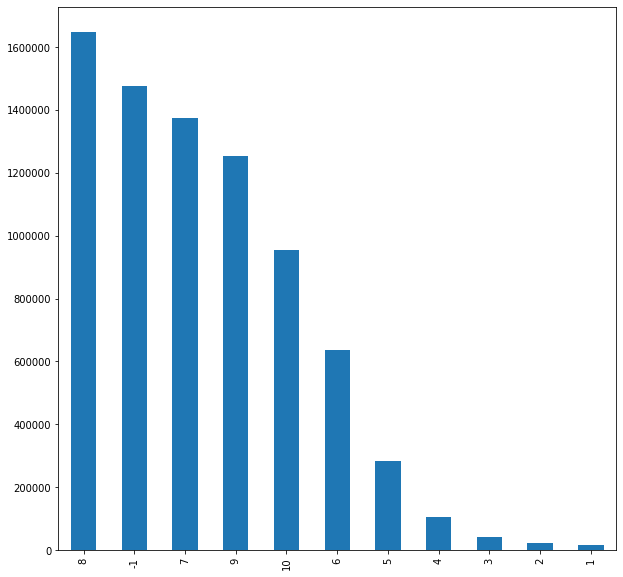

7813737

In [157]:
rating.rating.value_counts().plot(kind='bar',figsize=(10,10))
plt.show()
len(rating)

### Review amount filtered

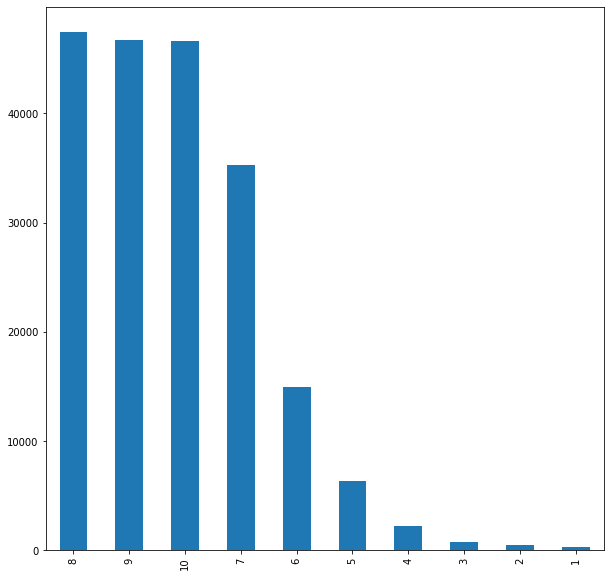

7813737

In [158]:
rating_x.rating.value_counts().plot(kind='bar',figsize=(10,10))
plt.show()
len(rating)

### Review amount - train data

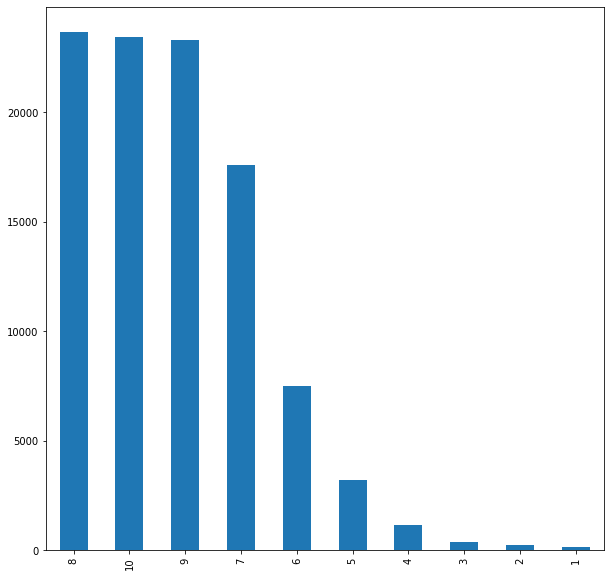

In [266]:

train,test = train_test_split(rating_x,shuffle = True, test_size = 0.5)
train.rating.value_counts().plot(kind='bar',figsize=(10,10))
plt.show()

## Model

### Cross validating KNN and SVD algorithms and RMSE & MSE score

In [171]:
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import knns
from surprise import SVDpp, SlopeOne, NMF, CoClustering, NormalPredictor, BaselineOnly
reader = Reader(rating_scale=(1, 10))
recom_ratings=Dataset.load_from_df(train[['user_id','anime_id','rating']],reader)

crossval_results = []

# Iterate over all algorithms
for algorithm in [ knns.KNNBaseline(), knns.KNNBasic(), knns.KNNWithMeans(), knns.KNNWithZScore(),SVD()]:
    
    # Perform cross validation
    results = cross_validate(algorithm, recom_ratings, measures=['RMSE','mae'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp_results = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp_results = tmp_results.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    crossval_results.append(tmp_results)

pd.DataFrame(crossval_results).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNBaseline,1.329097,1.022736,16.658637,14.311334
SVD,1.344240,1.050550,3.414896,0.369579
KNNBasic,1.385550,1.069286,15.578310,12.459650
KNNWithMeans,1.414626,1.062020,14.771950,12.797450
KNNWithZScore,1.419823,1.067794,17.373837,13.984204


In [174]:
#Save model scores to xlxs
pd.DataFrame(crossval_results).set_index('Algorithm').sort_values('test_rmse').to_excel('crossvalidation_results.xlsx')

In [182]:
from surprise import accuracy
trainset = recom_ratings.build_full_trainset()
#Make model
algo = knns.KNNBaseline()
predictions = algo.fit(trainset)
#accuracy.rmse(predictions)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


TypeError: 'KNNBaseline' object is not iterable

In [192]:
predictions.predict(uid= 1012, iid= 5)

Prediction(uid=1012, iid=5, r_ui=None, est=8.992560810018693, details={'actual_k': 40, 'was_impossible': False})

## Get recommendations for Samurai Champloo movie

In [258]:
#get inner id of samurai champloo movie
movieID=5

#get inner id of samurai champloo from the model
recom_inner_id = algo.trainset.to_inner_iid(movieID)

#get top 10 recommendations for the samurai champloo movie
recommendation = algo.get_neighbors(recom_inner_id, k=10)

#get real ID's of recommended movies from original data
recommendation_neighbors = (algo.trainset.to_raw_iid(inner_id)for inner_id in recommendation)

#Print info of Samurai Champloo movie
filterByColumnValue(anime_x,'anime_id',[movieID])

,anime_id,name,genre,type,episodes,rating,members
152,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.4,137636


In [259]:
#Top 10 recommendations for person who watched movie samurai champloo
filterByColumnValue(anime_x,'anime_id',recommendation_neighbors)

,anime_id,name,genre,type,episodes,rating,members
71,578,Hotaru no Haka,"Drama, Historical",Movie,1,8.58,174878
312,15039,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Drama, Slice of Life, Supernatural",Movie,1,8.19,95241
609,13117,Hakuouki Movie 1: Kyoto Ranbu,"Action, Drama, Historical, Josei, Samurai, Sup...",Movie,1,7.94,12076
726,570,Jin-Rou,"Drama, Military, Police, Psychological, Romance",Movie,1,7.87,62464
798,33082,Kingsglaive: Final Fantasy XV,Action,Movie,1,7.83,15508
1014,5204,Kara no Kyoukai 6: Boukyaku Rokuon,"Action, Magic, Mystery, Romance, Supernatural,...",Movie,1,7.72,93803
1902,844,Konjiki no Gash Bell!!: 101 Banme no Mamono,"Adventure, Shounen, Supernatural",Movie,1,7.41,4425
3146,1260,Saint Seiya: Saishuu Seisen no Senshi-tachi,"Adventure, Sci-Fi, Shounen",Movie,1,7.07,8217
3202,502,Dragon Ball Movie 1: Shen Long no Densetsu,"Action, Adventure, Comedy, Fantasy, Shounen, S...",Movie,1,7.05,30279
3289,891,Dragon Ball Movie 2: Majinjou no Nemuri Hime,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Sh...",Movie,1,7.03,27194


In [248]:
#https://github.com/NicolasHug/Surprise/blob/master/examples/k_nearest_neighbors.py

1. What kind of preprocessing is necessary for the ratings dataset?
- Filtering data because there is too much to process
    - In our case we decided to build recommendation engine for anime movies.
    - filtered all users that had made over 100 reviews because we wanted input from diffrent kinds of people and decided buil recommendation system for common people.
    - Need run data through reader to be able to parse dataset
    - remove unrated information.

2. How do the recommendation algorithms (e.g. KNN and SVD) perform with a data set of this magnitude? Do you encounter hardware limitations? If yes, how can you circumvent some of the limitations to be able to carry on with the experiment?
    - SVD and KNN algorithms faced problem when we tried run the whole data scikit learn crashed due to the memory errors.
        - That is why we proceed filtering steps explained in previous section
    - SVD was much faster than KNN (how much)
        - It wasnt not far behind KNNBaseline in metrics but because it is X times faster than KNN it might be good option for huge datasets
    - Therer were many different KNN algorithms to choose from, but every one of them were much slower that SVD, but KNNBaseline had smallest RMSE so it was most valid choice for accurate model
    
3. Can you combine the information in the two files in a meaningful way to have the recommender display the titles of the recommended movies?
    - Files can be combined easly through the anime_id parameter but it needed couple of tricks to get real id's for movies from model that can see from "get recommendations..." part which is above this cell.
